In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import to_categorical
import keras
import keras_tuner
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input
from keras import backend as K
from keras.callbacks import EarlyStopping

In [2]:
#Load in filepaths for each class
cardboard_files = glob.glob("Cardboard/*.s2p")
metal_files = glob.glob("Metal/*.s2p")
plastic_files = glob.glob("Plastic/*.s2p")
keras.utils.set_random_seed(42)

In [3]:
#Count how many scans have been taken from each object in given filename set
#Classes variable gives more naming control
def count_scans(filenames, classes):
    counts = []
    for c in classes:
        for i in range(34):
            x = sum(1 for name in filenames if name.__contains__(f'{c}o{i}s'))
            if x != 0:
                counts.append(x)
    return counts

In [4]:
#Method for loading in the dataset.
#Returns the dataset as a numpy array 
def dataset(filepaths):
    dataset = np.empty((len(filepaths), 101, 5))
    for index, file in enumerate(filepaths):
        data = np.loadtxt(file, skiprows = 1, usecols = (0,1,2,3,4))
        dataset[index] = data
    return dataset

In [5]:
#Combine files into single array and check the count
files = cardboard_files + metal_files + plastic_files
print(len(files))

#Get a combined scans array for later use
scans = count_scans(files, ["c", "m", "p"])

#Load in data, remove the frequency column and check shape
data = dataset(files)
data = np.delete(data, 0, 2)
data.shape

1112


(1112, 101, 4)

In [6]:
#Individual scan counts for creating ground truth vector
c_scans=count_scans(cardboard_files, ["c"])
p_scans=count_scans(plastic_files, ["p"])
m_scans=count_scans(metal_files, ["m"])

#Create ground truth vector
c_gt = np.zeros([sum(c_scans), 1])
m_gt = np.ones([sum(m_scans), 1])
p_gt = np.zeros([sum(p_scans), 1])
y = np.concatenate((c_gt, m_gt, p_gt))

y.shape


(1112, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.1, random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)


### Hyperparameter optimization

#### Trial 1

In [10]:
def build_model(hp):
    input_shape = (101, 4)
    m_type = hp.Int('type', min_value=1, max_value=4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    if m_type == 1:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 2:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))

    if m_type == 3:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 4:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model,
    objective='val_loss',
    executions_per_trial=1,
    directory = 'bk_trial1',
    project_name = 'bk_trial1'
)

Reloading Tuner from bk_trial1\bk_trial1\tuner0.json


In [12]:
Gtuner.search(X_train, y_train, epochs=400, validation_data=(X_val, y_val), verbose = 2)

In [13]:
Gtuner.results_summary()

Results summary
Results in bk_trial1\bk_trial1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0006 summary
Hyperparameters:
type: 4
optimizer: adam
Score: 0.05012806877493858

Trial 0005 summary
Hyperparameters:
type: 3
optimizer: rmsprop
Score: 0.06377800554037094

Trial 0000 summary
Hyperparameters:
type: 1
optimizer: adam
Score: 0.0802132785320282

Trial 0003 summary
Hyperparameters:
type: 2
optimizer: rmsprop
Score: 0.08340995758771896

Trial 0007 summary
Hyperparameters:
type: 4
optimizer: rmsprop
Score: 0.08459159731864929

Trial 0001 summary
Hyperparameters:
type: 1
optimizer: rmsprop
Score: 0.08473178744316101

Trial 0002 summary
Hyperparameters:
type: 2
optimizer: adam
Score: 0.08726214617490768

Trial 0004 summary
Hyperparameters:
type: 3
optimizer: adam
Score: 0.08786992728710175


In [14]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       207,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,718,017 (6.55 MB)

 Trainable params: 1,718,017 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
predictions = best_model.predict(X_test, verbose=0)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

Test set accuracy: 0.9821428656578064


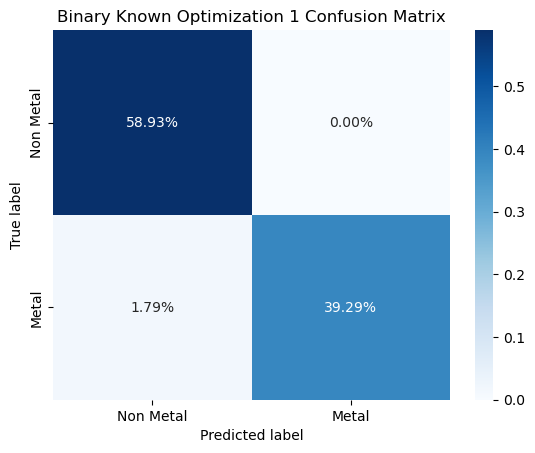

In [16]:
predictions = [round(x[0]) for x in predictions]
categories = ["Non Metal","Metal"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Binary Known Optimization 1 Confusion Matrix')
plt.savefig('Graphs/Binary_Known_Trial1.png')

#### Trial 2

In [18]:
def build_model_2(hp):
    input_shape = (101, 4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    for i in range(hp.Int('num_large_layers', min_value=0, max_value=1)):
        model.add(Dense(1024, activation = 'relu'))
    for i in range(hp.Int('num_mid_layers', min_value=3, max_value=6)):
        model.add(Dense(512, activation = 'relu'))
    for i in range(hp.Int('num_small_layers', min_value=1, max_value=3)):
        model.add(Dense(256, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [19]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model_2,
    objective='val_loss',
    executions_per_trial=1,
    directory = 'bk_trial2',
    project_name = 'bk_trial2'
)

Reloading Tuner from bk_trial2\bk_trial2\tuner0.json


In [20]:
Gtuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val), verbose = 2)

In [21]:
Gtuner.results_summary()

Results summary
Results in bk_trial2\bk_trial2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0005 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 4
num_small_layers: 3
Score: 0.05301382392644882

Trial 0023 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 6
num_small_layers: 3
Score: 0.06477918475866318

Trial 0006 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 5
num_small_layers: 1
Score: 0.0697619840502739

Trial 0007 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 5
num_small_layers: 2
Score: 0.06979312747716904

Trial 0010 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 6
num_small_layers: 2
Score: 0.06981348246335983

Trial 0009 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 6
num_small_layers: 1
Score: 0.06990440934896469

Trial 0020 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 5
num_small_layers: 3
Score: 0.07150046527385712

Trial 0011 summary
Hyperparamete

In [22]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       207,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,258,497 (4.80 MB)

 Trainable params: 1,258,497 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
predictions = best_model.predict(X_test, verbose=0)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

Test set accuracy: 1.0


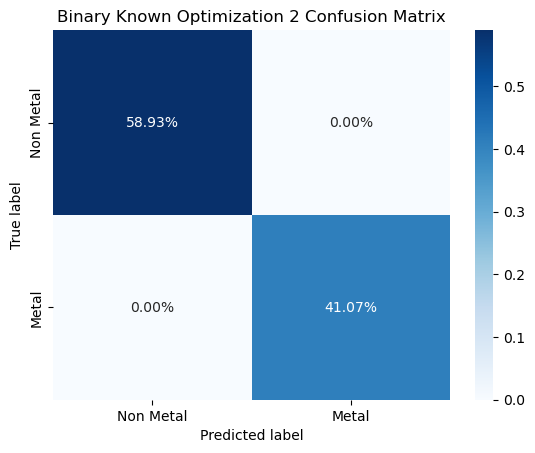

In [24]:
predictions = [round(x[0]) for x in predictions]
categories = ["Non Metal","Metal"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Binary Known Optimization 2 Confusion Matrix')
plt.savefig('Graphs/Binary_Known_Trial2.png')

### K-fold validation of previous models

In [26]:
initializer = keras.initializers.GlorotUniform(seed=42)

In [27]:
def build_k_fold_model():
    input_shape = (101, 4)

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(units=512, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=512, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=512, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=512, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=256 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=256 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=256 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [28]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
from sklearn.model_selection import KFold

accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
cf_matrices = []
objects = list(range(len(scans)))
kf = KFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f'Fold {fold + 1}')

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)

    model = build_k_fold_model()
    
    model.fit(X_train, y_train,
              epochs=500,
              batch_size=128,
              validation_data=(X_val, y_val),
              callbacks = [model_checkpoint_callback],
              verbose=0)

    
    model = keras.models.load_model("binary_model.keras")
    
    predictions = model.predict(X_test)
    predictions = [round(x[0]) for x in predictions] 
    accuracy = accuracy_score(y_test, predictions)

    values = precision_recall_fscore_support(y_test, predictions, average='macro')
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)


    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(values[0])
    recall_per_fold.append(values[1])
    f1_per_fold.append(values[2])
    cf_matrices.append(cf_matrix)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {values[0] * 100:.2f}%')
    print(f'Recall: {values[1] * 100:.2f}%')
    print(f'F1-score: {values[2]:.4f}')

average_accuracy = np.mean(accuracy_per_fold)
average_precision = np.mean(precision_per_fold)
average_recall = np.mean(recall_per_fold)
average_f1 = np.mean(f1_per_fold)
print(f'\nAverage Accuracy Across {10} Folds: {average_accuracy * 100:.2f}%')
print(f'\nAverage Precision Across {10} Folds: {average_precision * 100:.2f}%')
print(f'\nAverage Recall Across {10} Folds: {average_recall * 100:.2f}%')
print(f'\nAverage F1-score Across {10} Folds: {average_f1:.4f}')

Fold 1
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002049DC97600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 96.43%
Precision: 94.87%
Recall: 97.40%
F1-score: 0.9596
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy: 94.64%
Precision: 92.31%
Recall: 96.20%
F1-score: 0.9386
Fold 3
4/4 

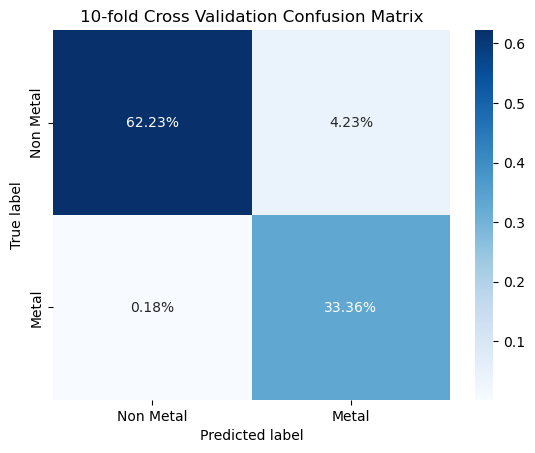

In [30]:
av_cf = sum(cf_matrices)
sns.heatmap(av_cf/np.sum(av_cf), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('10-fold Cross Validation Confusion Matrix')
plt.savefig('Graphs/Binary_Known_k-fold.png')